# Kikuchi Band Detection using the Hough Transform

ACQUIRE - PARSE - FILTER - __MINE__ - REPRESENT - REFINE - INTERACT

## Motivation

The detection of Kikuchi bands is a first step towards the extraction of quantitative crystallographic information beyond pure pixel intensities.

**Initialization code**

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

import numpy as np


import skimage.io
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from skimage.filters import threshold_otsu

from skimage.transform import (hough_line, hough_line_peaks,
    probabilistic_hough_line)

from scipy.ndimage.filters import correlate

from aloe.plots import plot_image
from aloe.image.kikufilter import img_to_uint
from aloe.image.downsample import downsample

## Loading the Filtered Data

From the previous pattern processing step, we can load a single binned pattern, in 8bit range:

(60, 80) uint8


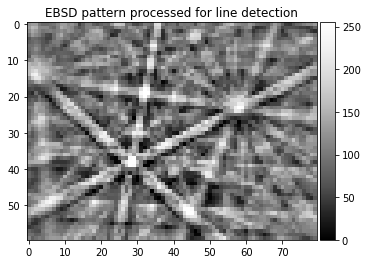

In [21]:
pattern=skimage.io.imread('./data/Si/Si_img8_binned.tif', plugin='tifffile')
#pattern=downsample(pattern,2)
print(pattern.shape, pattern.dtype)
plot_image(pattern, title='EBSD pattern processed for line detection')

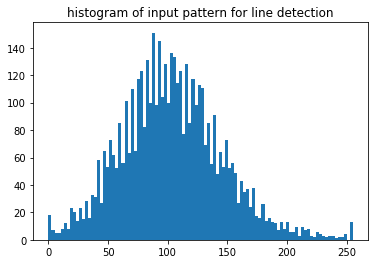

In [22]:
n, bins, patches = plt.hist(np.ravel(pattern), bins=100)
plt.title('histogram of input pattern for line detection')
plt.show()

8bit pattern, 255 gray scales, relatively low contrast, large background offset
camera: gain + offset settings, cannot be optimized for each pattern in the map, compromise for whole map with possibly strongly varying  signal

## Hough Transform Band Detection

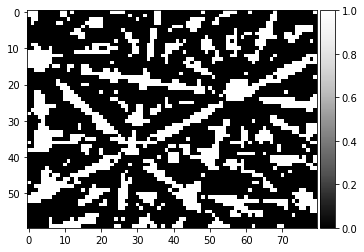

In [32]:
def otsu(img, factor=1.15):
    """ return True/False array from thresholding the image """
    thresh = factor*threshold_otsu(img)
    binary = img > thresh
    return binary

binary=otsu(pattern).astype(int)
plot_image(binary)

#skimage.io.imsave('./results/img8_binary.png', 255*binary)

float64


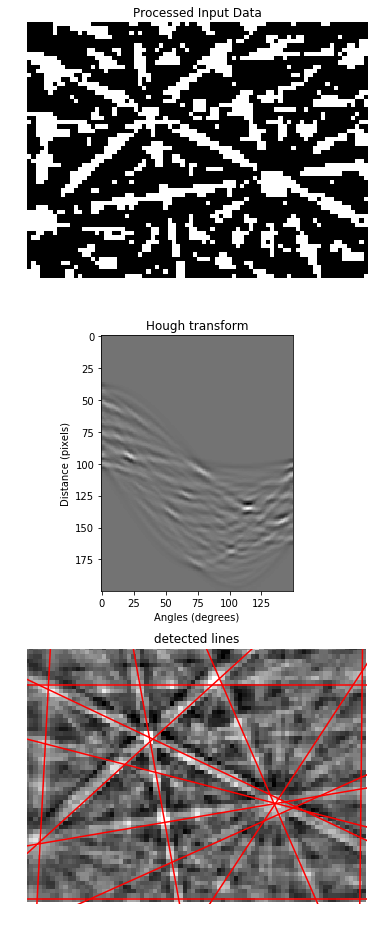

In [58]:
# Classic straight-line Hough transform from binary data.
image=np.flipud(binary)
background=np.ones_like(image)

ang=np.deg2rad(np.linspace(-90,90,150))
h, theta, d = hough_line(image, theta=ang)
#hb, thetab, db = hough_line(background, theta=ang)
#hb_masked=np.ma.masked_equal(hb,0)



h_masked = np.ma.masked_equal(h ,0)

#h_masked = h_masked / hb_masked

h_masked=h_masked/np.max(h_masked)
#a=1000*a/np.max(a)

#h16=np.round(a)



# butterfly mask convolution
# 9x9 mask Krieger-Lassen
k = np.array([[-10, -15, -22, -22, -22, -22, -22, -15, -10], 
              [  1,  -6, -13, -22, -22, -22, -13,  -6,   1], 
              [  3,   6,   4,  -3, -22,  -3,   4,   6,   3],
              [  3,  11,  19,  28,  42,  28,  19,  11,   3], 
              [  3,  11,  27,  42,  42,  42,  27,  11,   3], 
              [  3,  11,  19,  28,  42,  28,  19,  11,   3], 
              [  3,   6,   4,  -3, -22,  -3,   4,   6,   3], 
              [  1,  -6, -13, -22, -22, -22, -13,  -6,   1], 
              [-10, -15, -22, -22, -22, -22, -22, -15, -10] ])

h = correlate(h_masked, k, mode='nearest') #.astype(np.int64)


#h=h/np.max(h)
#a=np.exp()
a=(h-np.min(h))/(np.max(h)-np.min(h))
#a=a**3
#a=otsu(a,factor=1.5)
#a=np.exp(a)
print(a.dtype)


hpeaks=hough_line_peaks(a, theta, d,
        min_distance=10, min_angle=15, threshold=0.5*np.max(a), num_peaks=12)
#print('Hough peaks:', hpeaks)


# Generating figure 1.
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(6, 13))

ax0.imshow(image, cmap=cm.gray)
ax0.set_title('Processed Input Data')
ax0.set_axis_off()

#ax1.imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
#           d[-1], d[0]], cmap=cm.gray, aspect=1)
ax1.imshow(a,cmap=cm.gray)
ax1.set_title('Hough transform')
ax1.set_xlabel('Angles (degrees)')
ax1.set_ylabel('Distance (pixels)')
ax1.axis('image')

ax2.imshow(np.flipud(pattern), cmap=cm.gray)
row1, col1 = pattern.shape
linecount=1
houghkl=[]
houghlines=[]
for _, angle, dist in zip(*hpeaks):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    ax2.plot((0, col1), (y0, y1), '-r')
    houghlines.append([linecount, dist, np.degrees(angle), 0, y0, col1,y1 ])
    #print(linecount, dist, np.rad2deg(angle),gpc)
    linecount=linecount+1
ax2.axis((0, col1, row1, 0))
ax2.set_title('detected lines')
ax2.set_axis_off()
plt.tight_layout()
plt.show()
#plt.savefig('hough_simple.png')

In [56]:
#houghkl=np.asarray(houghkl)
print(houghlines)

[[1, 35.678391959798972, 47.718120805369125, 0, 48.224215232431931, 80, -24.523946829169351], [2, -6.5326633165829264, -64.630872483221481, 0, 7.2298661837367399, 80, 45.163847394797635], [3, 5.5276381909547609, 3.0201342281879278, 0, 104.91488948480423, 80, -1411.3807531052578], [4, 68.844221105527623, 33.22147651006712, 0, 125.65638260615498, 80, 3.5035254560373441], [5, 24.623115577889436, -10.268456375838923, 0, -138.12994371649842, 80, 303.46343984397163], [6, 59.798994974874347, 65.838926174496635, 0, 65.540442381124635, 80, 29.652325730616525], [7, 38.693467336683398, -23.557046979865774, 0, -96.815489778156632, 80, 86.672101106164675], [8, -46.733668341708551, -86.375838926174495, 0, 46.827315408001503, 80, 51.894358444633554], [9, -20.603015075376888, -75.503355704697981, 0, 21.280538409298831, 80, 41.964946408769734]]
